# ASML Case Study - Bias Reduction

## SETTING UP THE ENVIRONMENT

### Importing libraries

In [1]:
# General libraries
import os
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels as sm
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# Case study libraries
from ASML_functions import get_residuals

### Importing Data

In [3]:
# code for just the first sheet
'''
asml = pd.read_excel("ASML case data 2024.xlsx")
'''

'\nasml = pd.read_excel("ASML case data 2024.xlsx")\n'

In [4]:
# all sheets combined together
asml_sheet_dict = pd.read_excel("ASML case data 2024.xlsx", sheet_name=None)
asml = pd.concat(asml_sheet_dict.values(), ignore_index=True)

In [5]:
asml.shape

(7350, 12)

In [6]:
asml.head()

,wafer_id,field_center_x,field_center_y,intra_field_x,intra_field_y,wafer_coordinate_x_mm,wafer_coordinate_y_mm,Design_y_nm,Yieldproxy_y_perc,OVL_y_nm,L1_CD_y_nm,L2_CD_y_nm
0,1,-129.5348,-31.7107,-4.281,1.693,-0.133816,-0.030018,8,99.990000,-2.503573,20.732029,31.053869
1,1,-129.5348,-31.7107,-4.269,1.693,-0.133804,-0.030018,8,97.304645,-2.976532,22.140331,30.229045
2,1,-129.5348,-31.7107,-4.269,1.705,-0.133804,-0.030006,8,98.844177,-3.020233,21.859952,30.084430
3,1,-129.5348,-31.7107,-4.257,1.693,-0.133792,-0.030018,8,99.990000,-3.319554,22.780664,30.107721
4,1,-129.5348,-31.7107,-4.257,1.705,-0.133792,-0.030006,8,97.997447,-3.444417,22.489603,29.441237


### Cleaning data

In [7]:
asml.drop("Design_y_nm", axis='columns', inplace=True)
asml.rename(columns={'wafer_coordinate_x_mm': 'coordinate_x', 'wafer_coordinate_y_mm': 'coordinate_y',
                   'Yieldproxy_y_perc': 'Yield', 'OVL_y_nm': 'OVL', 'L1_CD_y_nm': 'L1_CD', 'L2_CD_y_nm': 'L2_CD',}, inplace=True)
asml.head()

,wafer_id,field_center_x,field_center_y,intra_field_x,intra_field_y,coordinate_x,coordinate_y,Yield,OVL,L1_CD,L2_CD
0,1,-129.5348,-31.7107,-4.281,1.693,-0.133816,-0.030018,99.990000,-2.503573,20.732029,31.053869
1,1,-129.5348,-31.7107,-4.269,1.693,-0.133804,-0.030018,97.304645,-2.976532,22.140331,30.229045
2,1,-129.5348,-31.7107,-4.269,1.705,-0.133804,-0.030006,98.844177,-3.020233,21.859952,30.084430
3,1,-129.5348,-31.7107,-4.257,1.693,-0.133792,-0.030018,99.990000,-3.319554,22.780664,30.107721
4,1,-129.5348,-31.7107,-4.257,1.705,-0.133792,-0.030006,97.997447,-3.444417,22.489603,29.441237


In [8]:
# converting overlay to absolute overlay
asml['OVL'] = abs(asml['OVL'])
asml.head()

,wafer_id,field_center_x,field_center_y,intra_field_x,intra_field_y,coordinate_x,coordinate_y,Yield,OVL,L1_CD,L2_CD
0,1,-129.5348,-31.7107,-4.281,1.693,-0.133816,-0.030018,99.990000,2.503573,20.732029,31.053869
1,1,-129.5348,-31.7107,-4.269,1.693,-0.133804,-0.030018,97.304645,2.976532,22.140331,30.229045
2,1,-129.5348,-31.7107,-4.269,1.705,-0.133804,-0.030006,98.844177,3.020233,21.859952,30.084430
3,1,-129.5348,-31.7107,-4.257,1.693,-0.133792,-0.030018,99.990000,3.319554,22.780664,30.107721
4,1,-129.5348,-31.7107,-4.257,1.705,-0.133792,-0.030006,97.997447,3.444417,22.489603,29.441237


## BIAS REDUCTION WITH DOUBLE MACHINE LEARNING

### Positional dataset

In [9]:
asml_geo_data = asml[['field_center_x', 'field_center_y', 'intra_field_x', 'intra_field_y', 'coordinate_x', 'coordinate_y']]
asml_geo_data.head()

,field_center_x,field_center_y,intra_field_x,intra_field_y,coordinate_x,coordinate_y
0,-129.5348,-31.7107,-4.281,1.693,-0.133816,-0.030018
1,-129.5348,-31.7107,-4.269,1.693,-0.133804,-0.030018
2,-129.5348,-31.7107,-4.269,1.705,-0.133804,-0.030006
3,-129.5348,-31.7107,-4.257,1.693,-0.133792,-0.030018
4,-129.5348,-31.7107,-4.257,1.705,-0.133792,-0.030006


###  Finding the best ML model for OVL, CD1 and CD2

In [10]:
# trying to fit all the predictive ML models in sklearn and choosing the best one of them
from sklearn.utils import all_estimators

# Get all estimators of type 'regressor'
# type_filter{“classifier”, “regressor”, “cluster”, “transformer”}
estimators = all_estimators(type_filter='regressor')

# Loop through the list of tuples to print just the name
for name, model in estimators:
    print(name)

ARDRegression
AdaBoostRegressor
BaggingRegressor
BayesianRidge
CCA
DecisionTreeRegressor
DummyRegressor
ElasticNet
ElasticNetCV
ExtraTreeRegressor
ExtraTreesRegressor
GammaRegressor
GaussianProcessRegressor
GradientBoostingRegressor
HistGradientBoostingRegressor
HuberRegressor
IsotonicRegression
KNeighborsRegressor
KernelRidge
Lars
LarsCV
Lasso
LassoCV
LassoLars
LassoLarsCV
LassoLarsIC
LinearRegression
LinearSVR
MLPRegressor
MultiOutputRegressor
MultiTaskElasticNet
MultiTaskElasticNetCV
MultiTaskLasso
MultiTaskLassoCV
NuSVR
OrthogonalMatchingPursuit
OrthogonalMatchingPursuitCV
PLSCanonical
PLSRegression
PassiveAggressiveRegressor
PoissonRegressor
QuantileRegressor
RANSACRegressor
RadiusNeighborsRegressor
RandomForestRegressor
RegressorChain
Ridge
RidgeCV
SGDRegressor
SVR
StackingRegressor
TheilSenRegressor
TransformedTargetRegressor
TweedieRegressor
VotingRegressor


In [11]:
# escluding estimators that cause issues in the double machine learning custom function
exclusions = {'QuantileRegressor'}
estimators = [(name, cls) for name, cls in estimators if name not in exclusions]

In [12]:
# Cross validating all models and choosing the one that best predicts L1_CD using positional data in cross validation. 
# Then, fitting the model with all data and getting the residuals.
# The same will be done with OVL, L1 CD and L2 CD. 
# We will then have a residuals dataset which had the positional bias 
# removed with the best ML algorithm for the respective variable.

best_model_name_L1_CD, best_model_L1_CD, y_pred_L1_CD, residuals_L1_CD, results_table_L1_CD = get_residuals(asml_geo_data, asml['L1_CD'], models = estimators, random_seed = 123, timeout= 120, display_warnings = True, print_results_table = True)

MODEL ----------------------------- CV R^2
ARDRegression                       73.08%
AdaBoostRegressor                   72.80%
BaggingRegressor                    66.26%
BayesianRidge                       73.09%
CCA                                 Model fit error: `n_components` upper bound is 1. Got 2 instead. Reduce `n_components`.
DecisionTreeRegressor               66.05%
DummyRegressor                      -0.02%
ElasticNet                          -0.05%
ElasticNetCV                        25.13%
ExtraTreeRegressor                  66.04%
ExtraTreesRegressor                 66.05%
GammaRegressor                      0.00%
GaussianProcessRegressor            70.89%
GradientBoostingRegressor           74.91%
HistGradientBoostingRegressor       74.96%
HuberRegressor                      72.87%
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

Iso

In [13]:

best_model_name_L2_CD, best_model_L2_CD, y_pred_L2_CD, residuals_L2_CD, results_table_L2_CD = get_residuals(asml_geo_data, asml['L2_CD'], models = estimators, random_seed = 123, timeout= 120, display_warnings = True, print_results_table = True)

MODEL ----------------------------- CV R^2
ARDRegression                       62.01%
AdaBoostRegressor                   63.38%
BaggingRegressor                    50.93%
BayesianRidge                       62.01%
CCA                                 Model fit error: `n_components` upper bound is 1. Got 2 instead. Reduce `n_components`.
DecisionTreeRegressor               50.45%
DummyRegressor                      -0.01%
ElasticNet                          -0.03%
ElasticNetCV                        22.60%
ExtraTreeRegressor                  50.45%
ExtraTreesRegressor                 50.45%
GammaRegressor                      -0.03%
GaussianProcessRegressor            57.81%
GradientBoostingRegressor           64.24%
HistGradientBoostingRegressor       63.45%
HuberRegressor                      61.84%
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

Is

In [14]:
best_model_name_OVL, best_model_OVL, y_pred_OVL, residuals_OVL, results_table_OVL = get_residuals(asml_geo_data, asml['OVL'], models = estimators, random_seed = 123, timeout= 120, display_warnings = True, print_results_table = True)

MODEL ----------------------------- CV R^2
ARDRegression                       3.16%
AdaBoostRegressor                   0.56%
BaggingRegressor                    -23.05%
BayesianRidge                       3.20%
CCA                                 Model fit error: `n_components` upper bound is 1. Got 2 instead. Reduce `n_components`.
DecisionTreeRegressor               -25.19%
DummyRegressor                      -0.00%
ElasticNet                          0.14%
ElasticNetCV                        -0.00%
ExtraTreeRegressor                  -25.28%
ExtraTreesRegressor                 -25.20%
GammaRegressor                      0.13%
GaussianProcessRegressor            -3.91%
GradientBoostingRegressor           7.49%
HistGradientBoostingRegressor       11.00%
HuberRegressor                      -1.81%
IsotonicRegression                  Model fit error: Isotonic regression input X should be a 1d array or 2d array with 1 feature
KNeighborsRegressor                 -6.87%
KernelRidge       

In [15]:

best_model_name_Yield, best_model_Yield, y_pred_Yield, residuals_Yield, results_table_Yield = get_residuals(asml_geo_data, asml['Yield'], models = estimators, random_seed = 123, timeout= 120, display_warnings = True, print_results_table = True)

MODEL ----------------------------- CV R^2
ARDRegression                       44.21%
AdaBoostRegressor                   50.14%
BaggingRegressor                    40.83%
BayesianRidge                       44.24%
CCA                                 Model fit error: `n_components` upper bound is 1. Got 2 instead. Reduce `n_components`.
DecisionTreeRegressor               39.82%
DummyRegressor                      -0.04%
ElasticNet                          -0.04%
ElasticNetCV                        0.58%
ExtraTreeRegressor                  39.75%
ExtraTreesRegressor                 39.82%
GammaRegressor                      Model fit error: Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor            50.01%
GradientBoostingRegressor           55.49%
HistGradientBoostingRegressor       54.90%
HuberRegressor                      -12.14%
IsotonicRegression                  Model fit error: Isotonic regression input X should be a 1d array o

### Residual Dataset

In [16]:
asml_res = asml[['wafer_id']].copy()
asml_res = asml_res.assign(
    res_Yield = residuals_Yield,
    res_OVL=residuals_OVL,
    res_L1_CD=residuals_L1_CD,
    res_L2_CD=residuals_L2_CD)
asml_res

,wafer_id,res_Yield,res_OVL,res_L1_CD,res_L2_CD
0,1,0.338796,-0.660477,1.313265,0.337432
1,1,-2.073921,-0.187518,1.626656,-0.385745
2,1,-0.062992,-0.143817,1.240921,-0.535638
3,1,1.608892,0.155504,1.385403,0.074616
4,1,0.177048,0.280366,0.956613,-0.617753
...,...,...,...,...,...
7345,5,-0.356056,1.101372,0.456907,-0.671538
7346,5,-3.060945,1.213893,0.247188,-0.338752
7347,5,-8.416580,1.297321,0.552276,-0.722560
7348,5,-12.667498,1.740963,0.097877,-0.458051


In [20]:
# Merging my code with the code from Phil

# transforming my df into an excel file

asml_res.to_excel('ASML case data 2024 bias removed.xlsx', index=False)  # `index=False` means do not write row indices

In [23]:
def load_excel_to_arrays(file_path):
    # Load the Excel file
    xls = pd.ExcelFile(file_path)
    
    # Create an empty dictionary to hold sheet names and arrays
    arrays_dict = {}
    
    # Iterate through each sheet in the Excel file
    for sheet_name in xls.sheet_names:
        # Read the sheet into a DataFrame
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        
        # Get the headers from the first row
        headers = df.columns.tolist()

        # Convert the DataFrame to a NumPy array
        array = df.to_numpy()
        
        # Add the array to the dictionary with sheet name as key
        arrays_dict[sheet_name] = array
    
    return arrays_dict, headers

In [26]:
print(arrays_dict.keys())

dict_keys(['Sheet1'])


In [42]:

# CODE FROM PHIL

# I commented out the load_excel_to_arrays, I was not able to import if for some reason. I pasted it above for this reason.


#import ASML_functions as fn
import numpy as np
import matplotlib.pyplot as pl
import statsmodels.api as sm
from sklearn.linear_model import Lasso, Ridge, LassoLarsCV, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet

# Load the data
file_path = 'ASML case data 2024 bias removed.xlsx'

#arrays_dict, headers = fn.load_excel_to_arrays(file_path)
arrays_dict, headers = load_excel_to_arrays(file_path)

# Sample the first wafer

# with the data I have, the array was just 'Sheet1'
df_reg = arrays_dict['Sheet1'][:, -4:]
#df_reg = arrays_dict['Wafer 1'][:, -4:]
# (OVL, L1_CD, L2_CD, OVL_L2_CD, OVL_2, L2CD_2_L1CD)

OVL_L2CD  = df_reg[:, 1] * df_reg[:, 3]
OVL_2  = df_reg[:, 1] * df_reg[:, 1]
L2CD_2_L1CD = df_reg[:, 3] * df_reg[:, 3] * df_reg[:, 2]

df_reg = np.hstack((df_reg, np.array([OVL_L2CD, OVL_2, L2CD_2_L1CD]).T))

# Load the data
file_path = 'ASML case data 2024.xlsx'
#arrays_dict, headers = fn.load_excel_to_arrays(file_path)
arrays_dict, headers = load_excel_to_arrays(file_path)
# y = df[:, -4]

# Split data into features and target
X = df_reg[:, 1:]
y = df_reg[:, 0]

# function for testing:
# OLS, Ridge/Lasso, Adaptive Lasso, kNN, Decision Tree
def function_tester(cv_size:int = 10, loss_function:str = 'neg_mean_squared_error'):

    BLUE = '\033[38;5;19m'
    GREEN = '\033[0;32m'
    BOLD = '\033[1m'
    RESET = '\033[0m'

    # Ordinary Least Squares (OLS) regression
    ols_model = LinearRegression()
    ols_scores = cross_val_score(ols_model, X, y, cv=cv_size, scoring=loss_function)
    ols_scores_mean = np.mean(ols_scores)
    print(f'\n {BLUE}OLS completed{RESET}')
    print(f'{GREEN}average CV score: {ols_scores_mean:.2f}')

    # OLS with Ridge regression
    alpha_best = 0
    ridge_model_best = None
    ridge_scores_mean_best = 1e99
    ridge_scores_best = None
    for alpha in range(11):
        alpha_1 = alpha * 0.1
        ridge_model = Ridge(alpha=alpha_1)
        ridge_scores = cross_val_score(ridge_model, X, y, cv=cv_size, scoring=loss_function)
        if np.mean(ridge_scores) < ridge_scores_mean_best:
            alpha_best = alpha_1
            ridge_model_best = ridge_model
            ridge_scores_mean_best = np.mean(ridge_scores)
            ridge_scores_best = ridge_scores
    print(f'\n {BLUE}OLS with Ridge completed{RESET}')
    print(f'best model parameters: {ridge_model_best.get_params()}')
    print(f'{GREEN}average CV score using best parameters: {ridge_scores_mean_best:.2f}{RESET}')

    # OLS with Adaptive Lasso
    lasso_adaptive_model = LassoLarsCV(cv=10)
    lasso_adaptive_scores = cross_val_score(lasso_adaptive_model, X, y, cv=cv_size, scoring=loss_function)
    lasso_adaptive_mean_scores = np.mean(lasso_adaptive_scores)
    print(f'\n {BLUE}OLS with Adaptive Lasso{RESET}')
    print(f'{GREEN}average CV score: {lasso_adaptive_mean_scores:.2f}')

    # k-Nearest Neighbors (KNN)
    n_neighbors_best = 1
    knn_model_best = None
    knn_scores_mean_best = 1e99
    knn_scores_best = None
    for n_neighbors_1 in range(5, 51, 5):
        knn_model = KNeighborsRegressor(n_neighbors=5)  # You can adjust the number of neighbors
        knn_scores = cross_val_score(knn_model, X, y, cv=cv_size, scoring=loss_function)
        if np.mean(knn_scores) < knn_scores_mean_best:
            n_neighbors_best = n_neighbors_1
            knn_model_best = knn_model
            knn_scores_mean_best = np.mean(knn_scores)
            knn_scores_best = knn_scores
    print(f'\n {BLUE}KNN completed{RESET}')
    print(f'best model parameters: {knn_model_best.get_params()}')
    print(f'{GREEN}average CV score using best parameters: {knn_scores_mean_best:.2f}{RESET}')
    
    # Decision Tree with pruning
    max_depth_best = 0
    tree_model_best = None
    tree_scores_mean_best = 1e99
    tree_scores_best = None
    for max_depth_1 in range(5, 51, 5):
        tree_model = DecisionTreeRegressor(max_depth=max_depth_1)  # You can adjust the maximum depth
        tree_scores = cross_val_score(tree_model, X, y, cv=cv_size, scoring=loss_function)
        if np.mean(tree_scores) < tree_scores_mean_best:
            max_depth_best = max_depth_1
            tree_model_best = tree_model
            tree_scores_mean_best = np.mean(tree_scores)
            tree_scores_best = tree_scores
    print(f'\n {BLUE}Decision Tree completed{RESET}')
    print(f'best max depth: {max_depth_best}')
    print(f'best model parameters: {tree_model_best.get_params()}')
    print(f'{GREEN}average CV score using best parameters: {tree_scores_mean_best:.2f}{RESET}')
    
    # SVR
    print(f'\n {BOLD}Fitting SVR{RESET}')
    C_best = 1
    kernel_best = 'rbf'
    svr_scores_best = None
    svr_scores_mean_best = 1e99
    for C in [0.1, 1, 10]:
        print('fitting model in cross validation with:')
        print(f' C = {C}')
        for kernel in ['linear', 'rbf']:
            print(f' kernel = {kernel}')
            svr_model = SVR(C=C, kernel=kernel)
            svr_scores = cross_val_score(svr_model, X, y, cv=cv_size, scoring=loss_function)
            if np.mean(svr_scores) < svr_scores_mean_best:
                C_best = C
                kernel_model_best = kernel
                svr_model_best = svr_model
                svr_scores_best = svr_scores
                svr_scores_mean_best = np.mean(svr_scores)
    print(f'\n {BLUE}SVR completed{RESET}')
    print(f'best C: {C_best}')
    print(f'best kernel: {kernel_model_best}')
    print(f'best model parameters: {svr_model_best.get_params()}')
    print(f'{GREEN}average CV score using best parameters: {svr_scores_mean_best:.2f}{RESET}')
    
    # Random Forest with tuning for number of trees
    print(f'\n {BOLD}Fitting Random Forest{RESET}')
    n_estimators_rf_best = 0
    rf_scores_best = None
    rf_scores_mean_best = 1e99
    for n_estimators in [1, 5, 10, 50, 100]:
        print(f'fitting model in cross validation with n_estimators = {n_estimators}')
        rf_model = RandomForestRegressor(n_estimators=n_estimators, n_jobs = -1)
        rf_scores = cross_val_score(rf_model, X, y, cv=cv_size, scoring=loss_function)
        if np.mean(rf_scores) < rf_scores_mean_best:
            n_estimators_rf_best = n_estimators
            rf_model_best = rf_model
            rf_scores_best = rf_scores
            rf_scores_mean_best = np.mean(rf_scores)
    print(f'\n {BLUE}Random Forest completed{RESET}')
    print(f'best number of estimators: {n_estimators_rf_best}')
    print(f'best model parameters: {tree_model_best.get_params()}')
    print(f'{GREEN}average CV score using best parameters: {rf_scores_mean_best:.2f}{RESET}')
    
    # Gradient Boosting with tuning for number of trees
    print(f'\n {BOLD}Fitting Gradient Boosting{RESET}')
    gb_scores_best = None
    gb_scores_mean_best = 1e99
    n_estimators_gb_best = 0
    for n_estimators in [100, 250, 400, 600]:
        print(f'fitting model in cross validation with n_estimators = {n_estimators}')
        gb_model = GradientBoostingRegressor(n_estimators=n_estimators)
        gb_scores = cross_val_score(gb_model, X, y, cv=cv_size, scoring=loss_function)
        if np.mean(gb_scores) < gb_scores_mean_best:
            n_estimators_gb_best = n_estimators
            gb_scores_best = gb_scores
            gb_model_best = gb_model
            gb_scores_mean_best = np.mean(gb_scores)
    print(f'\n {BLUE}Gradient Boosting completed{RESET}')
    print(f'best number of estimators: {n_estimators_gb_best}')
    print(f'best model parameters: {gb_model_best.get_params()}')
    print(f'{GREEN}average CV score using best parameters: {gb_scores_mean_best:.2f}{RESET}')
    
    # XGBoost with tuning for number of trees
    print(f'\n {BOLD}Fitting XGBoost{RESET}')
    xgb_scores_best = None
    xgb_scores_mean_best = 1e99
    for n_estimators in [1, 5, 10, 50, 100]:
        print(f'fitting model in cross validation with n_estimators = {n_estimators}')
        xgb_model = XGBRegressor(n_estimators=n_estimators,n_jobs=-1)
        xgb_scores = cross_val_score(xgb_model, X, y, cv=cv_size, scoring=loss_function)
        if np.mean(xgb_scores) < xgb_scores_mean_best:
            xgb_scores_best = xgb_scores
            xgb_model_best = xgb_model
            n_estimators_xgb_best = n_estimators
            xgb_scores_mean_best = np.mean(xgb_scores)
    print(f'\n {BLUE}Gradient Boosting completed{RESET}')
    print(f'best number of estimators: {n_estimators_xgb_best}')
    print(f'best model parameters: {xgb_model_best.get_params()}')
    print(f'{GREEN}average CV score using best parameters: {xgb_scores_mean_best:.2f}{RESET}')
    
    # Elastic Net with tuning for alpha and l1_ratio
    print(f'\n {BOLD}Fitting Elastic Net{RESET}')
    elastic_net_scores_best = None
    elastic_net_scores_mean_best = 1e99
    best_alpha = 0
    best_l1_ratio = 0
    for alpha in [0.01, 0.1, 1]:
        print('fitting model in cross validation with:')
        print(f' alpha = {alpha}')
        for l1_ratio in [0.2, 0.5, 0.8]:
            print(f' l1_ratio = {l1_ratio}')
            en_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
            elastic_net_scores = cross_val_score(en_model, X, y, cv=cv_size, scoring=loss_function)
            if np.mean(elastic_net_scores) < elastic_net_scores_mean_best:
                elastic_net_scores_best = elastic_net_scores
                best_alpha = alpha
                best_l1_ratio = l1_ratio
                elastic_net_model_best = en_model
                elastic_net_scores_mean_best = np.mean(elastic_net_scores)
    print(f'\n {BLUE}Elastic Net completed{RESET}')
    print(f'best alpha: {best_alpha}')
    print(f'best l1_ratio: {best_l1_ratio}')
    print(f'best model parameters: {elastic_net_model_best.get_params()}')
    print(f'{GREEN}average CV score using best parameters: {elastic_net_scores_mean_best:.2f}{RESET}')
    
    return (ols_scores, ridge_scores_best, lasso_adaptive_scores, knn_scores_best, tree_scores_best,
           svr_scores_best, rf_scores_best, gb_scores_best, xgb_scores_best, elastic_net_scores_best)


## Custom loss function
# custom scoring function
def custom_scoring_function(y_true, y_pred, alpha):
    # Penalize values below alpha and favor values above alpha
    score = ((y_pred >= alpha) * y_true).sum()  # penalize values below alpha
    score += ((y_pred < alpha) * (y_true - alpha)).sum()  # reward values above alpha
    return score

# Create the scorer
custom_scorer = make_scorer(custom_scoring_function, alpha=0.9)


## Setting up the parameters
# Set the CV sizes and loss functions
cv_sizes = (10, 20, 50, 100)
loss_functions = ('neg_mean_squared_error', 'neg_mean_absolute_percentage_error')


## Executing the tests
# for cv_size in cv_sizes:
#     for loss_function in loss_functions:
# Obtain the methods' scores5
(ols_scores, ridge_scores_best, lasso_adaptive_scores, knn_scores_best, tree_scores_best,
svr_scores_best, rf_scores_best, gb_scores_best, xgb_scores_best, elastic_net_scores_best) = function_tester(10, custom_scorer)


 OLS completed
CV score: -240.48

 OLS with Ridge completed
best model parameters: {'alpha': 0.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}
best CV score: -240.48

 OLS with Adaptive Lasso
CV score: -240.12

 KNN completed
best model parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
best CV score: -247.23

 Decision Tree completed
best max depth: 40
best model parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 40, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}
best CV score: -309.24

 Fitting SVR
fitting model in cross validation with:
 C = 0.1
 kernel = linear
 kernel = rbf
fitting model in cro

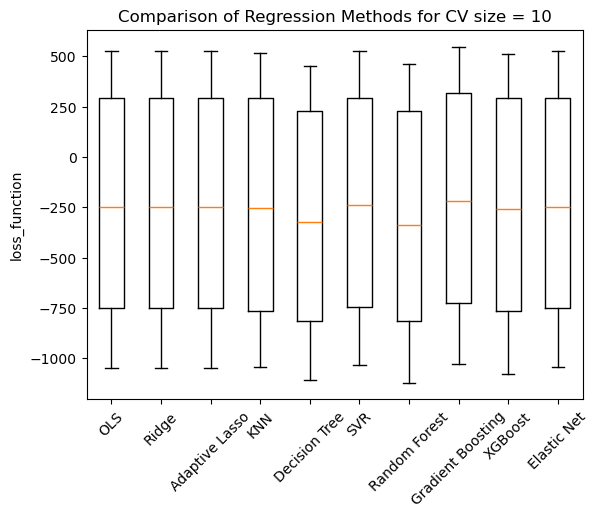

In [43]:
# Plotting the scores
plt.boxplot([ols_scores, ridge_scores_best, lasso_adaptive_scores, knn_scores_best, tree_scores_best,
            svr_scores_best, rf_scores_best, gb_scores_best, xgb_scores_best, elastic_net_scores_best],
            labels=['OLS', 'Ridge', 'Adaptive Lasso', 'KNN', 'Decision Tree', 
                    'SVR','Random Forest', 'Gradient Boosting','XGBoost','Elastic Net'])
plt.ylabel("loss_function")
plt.title('Comparison of Regression Methods for CV size = ' + str(10))
plt.xticks(rotation=45)
plt.savefig('plot_cv' + str(10) + '_loss_function_' + "loss_function" + '.png')